# Freight Market Dynamics - Dry Van Market - Data Prep

In [1]:
import numpy as np
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import seaborn as sns
from scipy.stats import skew, pearsonr
import statsmodels.api as sm

## Load data

### For fututre conveniance transform .dta file to .parquet

In [2]:
## raw data - Make it comment if already loaded
# df = pd.read_stata("data/data_extended.dta")
# df = df.drop(columns =['index'])
# df.to_parquet("data/data_extended.parquet", index=False)

In [3]:
df = pd.read_parquet("data/data_extended.parquet") 

## Data pre-processing

In [4]:
### Keep only dry van 
df = df[df['equip_type'] == 'V']

### Delete unecessary columns
df = df.drop(columns =[ 'miles', 'concat', 'concat_2', 'equip_type'])
df = df.rename(columns={'kma_ob': 'id'})

### Create week (sunday) feature

In [5]:
# Week period
df["t_period"] = df["date"].dt.to_period("W-SUN")

# Get Sunday date of the week - we need to do that  so end of the year weesk 53 is correctly handled
df["week"] = df["t_period"].dt.end_time.dt.normalize()
df = df.sort_values(by=['id', 'date'])

## Agregate to weekly KMA_OB level

In [6]:
df_kma_week = (
    df.groupby(['id', 'week'], as_index=False)
      .agg(
          lane=('lane', 'nunique'),
          R=('rate', 'mean'),
          F=('fuel_rate', 'mean'),
          E=('ep', 'sum'),
          L=('lp', 'sum'),
      )
)

df_kma_week.sort_values(['id', 'week'], inplace=True)

df_kma_week

,id,week,lane,R,F,E,L
0,AZ_PHO,2018-05-06,38,1.546141,NaN,35144.0,184587.0
1,AZ_PHO,2018-05-13,34,1.610149,NaN,46124.0,281069.0
2,AZ_PHO,2018-05-20,38,1.695826,NaN,42119.0,407592.0
3,AZ_PHO,2018-05-27,36,1.815482,NaN,41952.0,386037.0
4,AZ_PHO,2018-06-03,31,1.943128,NaN,32521.0,303407.0
...,...,...,...,...,...,...,...
7825,WI_MIL,2023-04-02,116,2.198338,0.519568,410090.0,594986.0
7826,WI_MIL,2023-04-09,117,2.180318,0.531304,405937.0,460402.0
7827,WI_MIL,2023-04-16,111,2.137137,NaN,384002.0,419863.0
7828,WI_MIL,2023-04-23,115,2.061471,NaN,441334.0,401402.0


### Fil lin Fuel (Fallback strategy)

In [7]:
# Create time features
df_kma_week['month']= df_kma_week['week'].dt.month
df_kma_week['year']= df_kma_week['week'].dt.year

### Fill in missing values - Fuel (F)
fuel_1 = df_kma_week.groupby(['id', 'year','month'])['F'].mean().reset_index()
fuel_1 = fuel_1.rename(columns={'F': 'F_1'})

fuel_2 = df_kma_week.groupby(['id', 'year'])['F'].mean().reset_index()
fuel_2 = fuel_2.rename(columns={'F': 'F_2'})

fuel_fallback = fuel_1.merge(fuel_2, on = ['id', 'year'], how = 'left')
fuel_fallback['F_fallback'] = fuel_fallback['F_1'].fillna(fuel_fallback['F_2'])

## Now merge back with df_kma_week 
df_kma_week = df_kma_week.merge(fuel_fallback[['id', 'year','month','F_fallback']], on = ['id', 'year','month'], how = 'left')
df_kma_week['F'] = df_kma_week['F'].fillna(df_kma_week['F_fallback'])
df_kma_week = df_kma_week.drop(columns=['F_fallback'])

df_kma_week.isnull().sum()/ len(df_kma_week)

id       0.0
week     0.0
lane     0.0
R        0.0
F        0.0
E        0.0
L        0.0
month    0.0
year     0.0
dtype: float64

### Time filter (If needed)

In [8]:
df_kma_week = df_kma_week[df_kma_week['year']>=2019]

### Create continuos time feature

In [ ]:
df_kma_week['t'] = (
    df_kma_week.groupby('id', observed=False)['week']
      .transform(lambda x: (x - x.min()).dt.days // 7 + 1)
)

#### Testing if we have any duplicated rows? 

In [11]:
# how many unique weeks overall?
T = df_kma_week['t'].nunique()
N = df_kma_week['id'].nunique()
print("N ids:", N, "T weeks:", T, "rows:", len(df_kma_week))

# per-id unique t count (should all equal T for a balanced panel)
# n_t_by_id = df_kma_week.groupby('id')['t'].nunique().sort_values()
# print(n_t_by_id.head(), n_t_by_id.tail())

# find duplicates of (id, t)
dups = (df_kma_week.groupby(['id','t']).size()
        .reset_index(name='n_rows')
        .query('n_rows > 1'))
print("duplicate (id,t) pairs:", len(dups))


N ids: 30 T weeks: 226 rows: 6780
duplicate (id,t) pairs: 0


### Compute Capacity Indicator

<Axes: xlabel='C', ylabel='Count'>

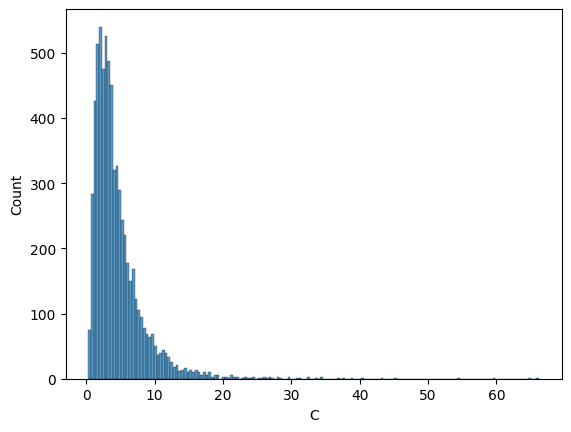

In [13]:
df_kma_week['C'] = df_kma_week['L'] / df_kma_week['E']
# display(df_kma_week['C'].describe())
sns.histplot(df_kma_week['C'])

### Compute Stats per KMA - Business Indicators

In [14]:
kma_stats = (
    df_kma_week.groupby('id', as_index=True)
      .agg(
        lane_mean=('lane', 'mean'),
        R_mean   =('R', 'mean'),
        R_std    =('R', 'std'),
        C_mean   =('C', 'mean'),
        C_max    =('C', 'max')
      )
)

kma_stats


,lane_mean,R_mean,R_std,C_mean,C_max
id,,,,,
AZ_PHO,59.544248,1.934951,0.536695,4.425542,13.877281
CA_LAX,117.455752,2.337293,0.693617,6.284652,18.217253
CA_ONT,105.495575,2.389572,0.665556,4.288164,14.488760
CO_DEN,88.831858,1.312967,0.266726,2.757405,12.568545
FL_LAK,86.924779,1.163922,0.259272,2.958760,11.476526
GA_ATL,121.092920,2.031551,0.420833,3.548240,11.202984
IL_CHI,130.880531,2.749045,0.587607,1.977075,7.080556
IL_JOL,129.407080,2.773506,0.585574,2.555268,8.767063
IN_IND,123.269912,2.535354,0.539458,3.061791,10.072592


### Re-set Capacity outliers 

{'threshold': np.float64(13.6233), 'capped_rows': 193}


<Axes: xlabel='C', ylabel='Count'>

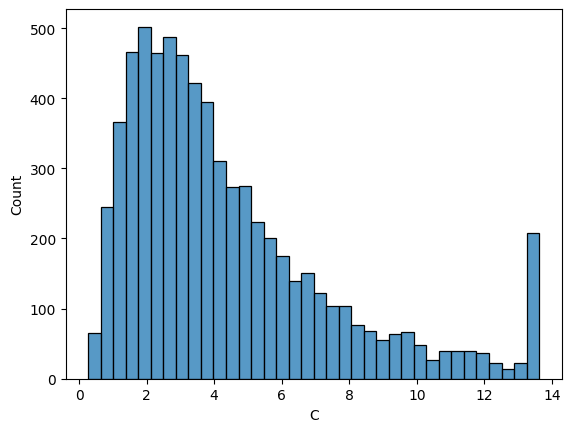

In [21]:
df_filtered = df_kma_week.copy()

# 1) compute global threshold on C (NaNs ignored)
q3  = df_filtered["C"].quantile(0.75)
sd  = df_filtered["C"].std()          # sample std (ddof=1 default)
thr = q3 + 2* sd

# 2) how many will be capped?
n_above = int((df_filtered["C"] > thr).sum())

# 3) replace values above threshold by the threshold
df_filtered["C"] = df_filtered["C"].clip(upper=thr)

print({"threshold": round(thr, 4), "capped_rows": n_above})
# print(df_filtered["C"].describe())

sns.histplot(df_filtered['C'])

### Chart 1 - Capacity cycle analysis per KMA - Evaluate necessity of time indicators

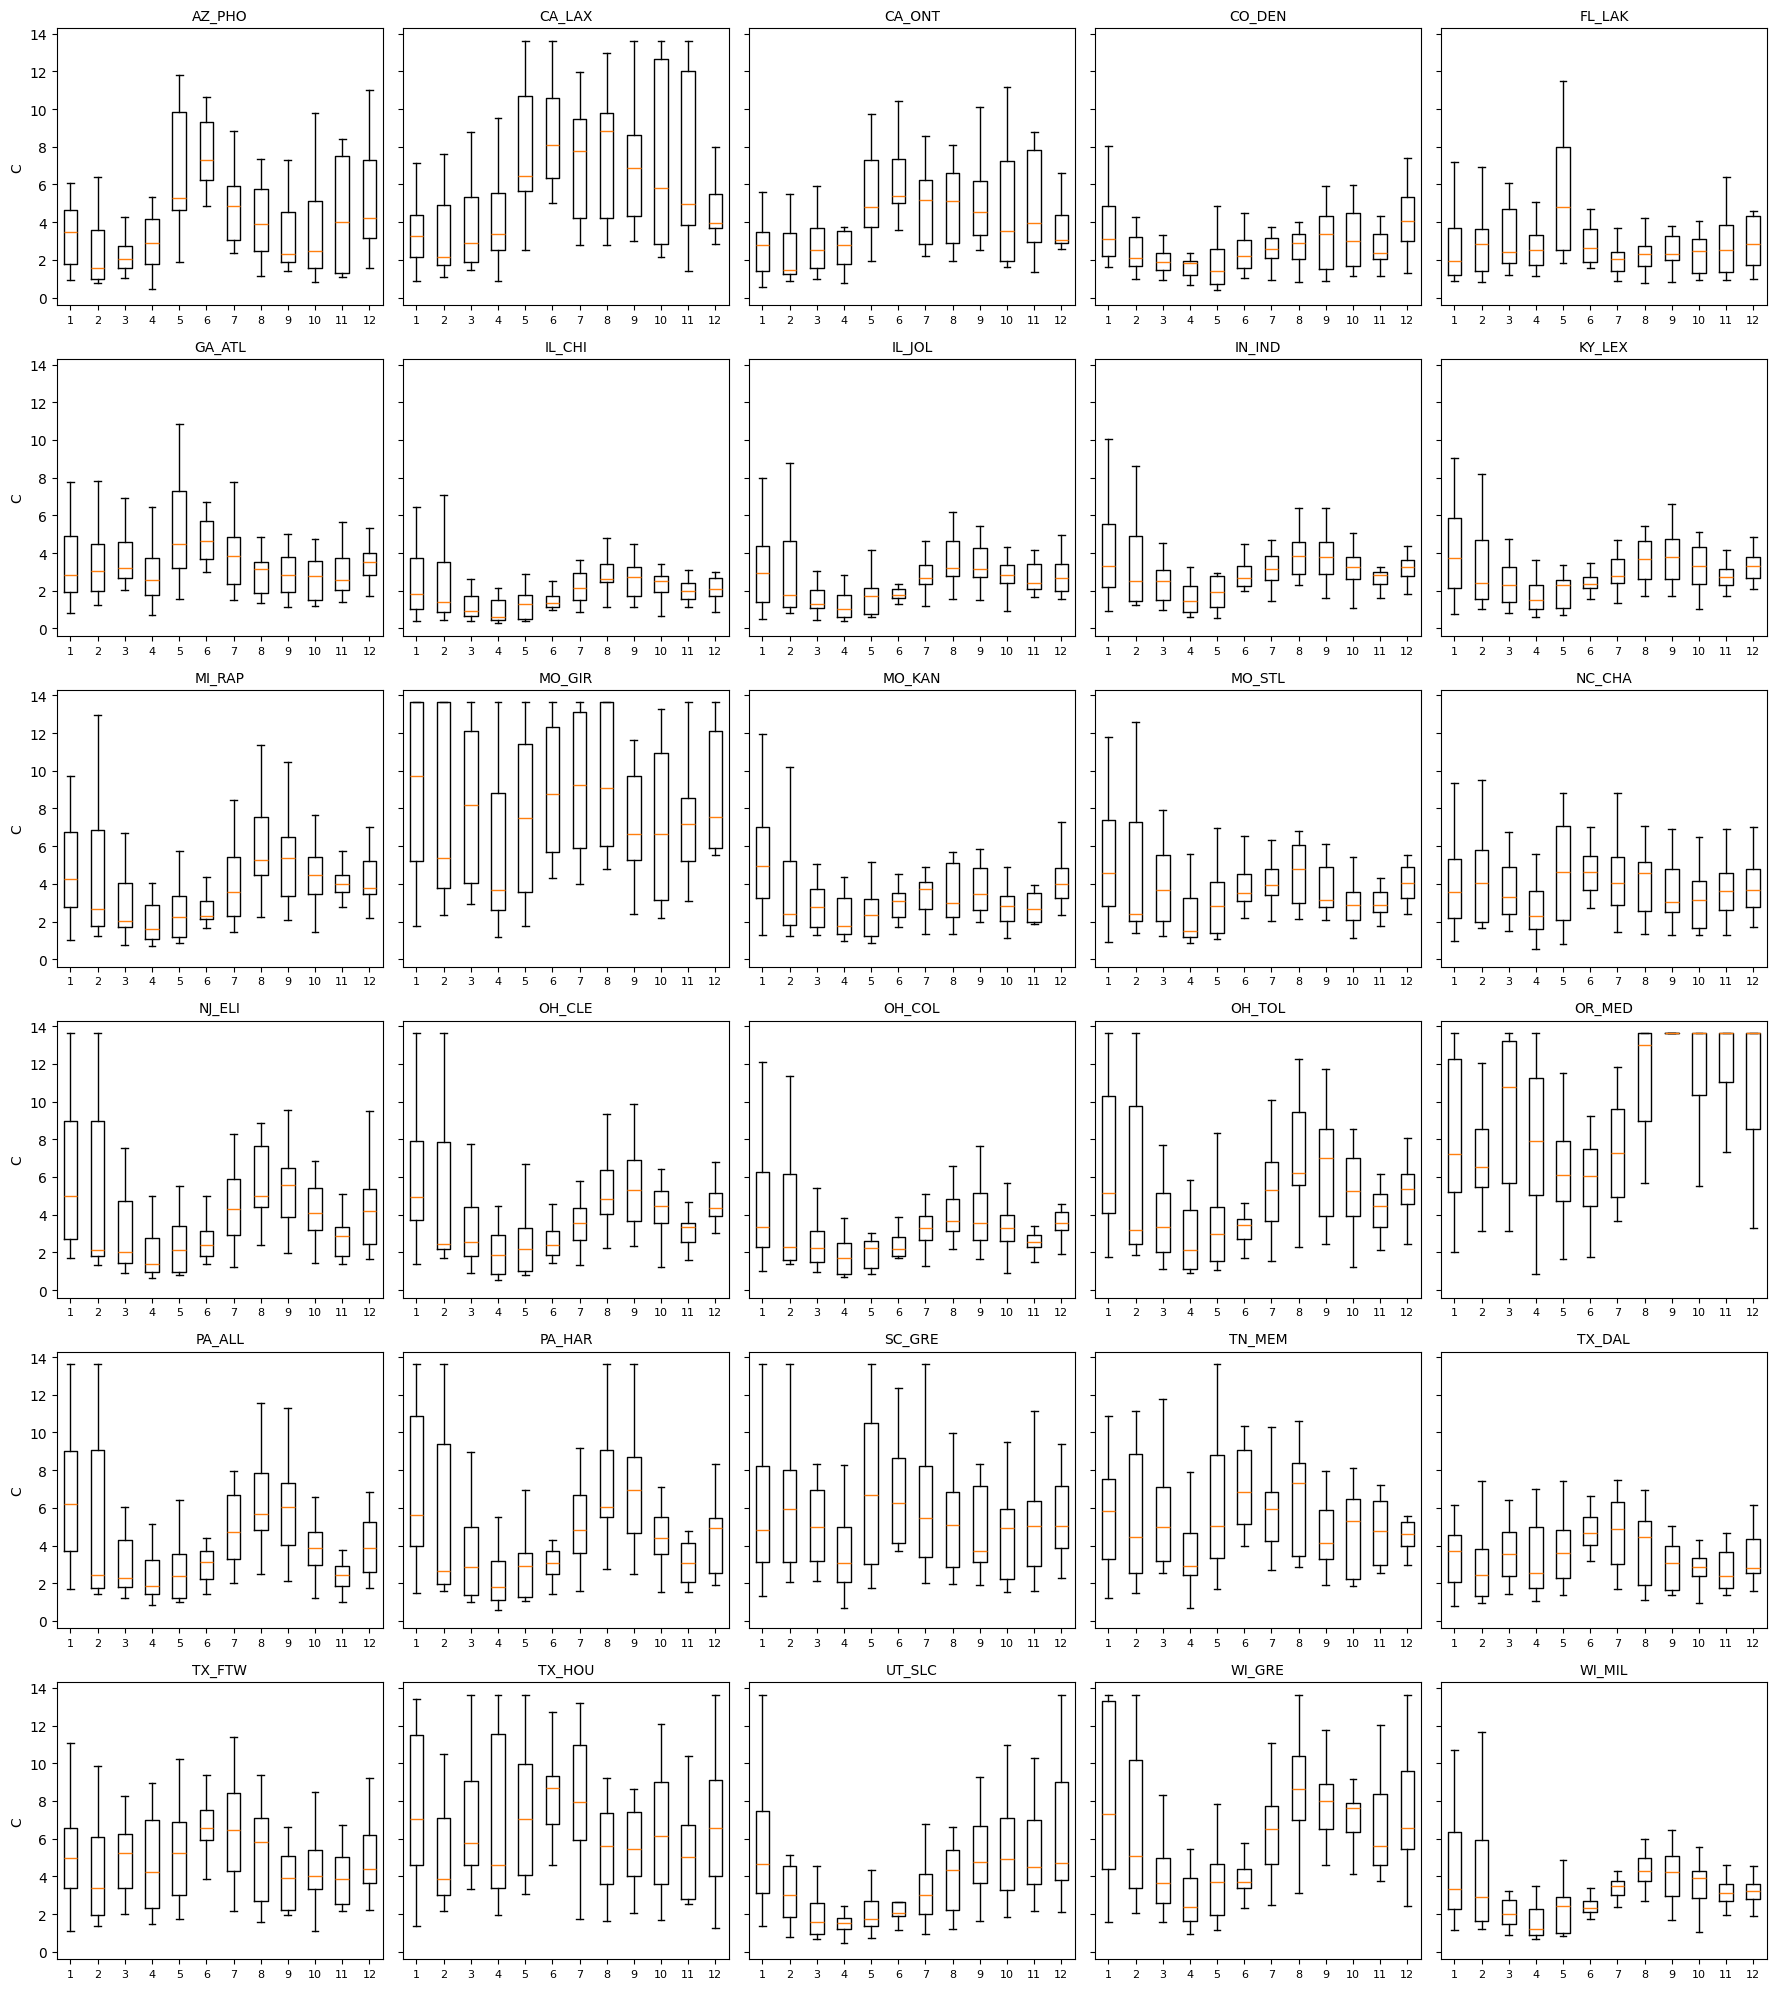

In [22]:
kmas = (df_filtered['id'].value_counts().head(30).index.tolist())
months = list(range(1, 13))

fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(18, 20), sharey=True)
axes = axes.ravel()

for i, k in enumerate(kmas):
    ax = axes[i]
    d = df_filtered.loc[df_filtered['id'] == k, ['month','C']]
    data = [d.loc[d['month'] == m, 'C'].values for m in months]
    ax.boxplot(data, showfliers=False)
    ax.set_title(k, fontsize=10)
    ax.set_xticks(np.arange(1, 13))
    ax.set_xticklabels(months, fontsize=8)
    if i % 5 == 0:
        ax.set_ylabel("C")

# hide any unused axes (if <30 KMA)
for j in range(len(kmas), len(axes)):
    axes[j].set_visible(False)

# fig.suptitle("C by Month per KMA (boxplots)", y=0.92, fontsize=14)
plt.tight_layout()
plt.show()


### Capacity ratios are higher in the second half of the year, likely driven by holidays, Black Friday, and winter conditions

#### Filter out KMAs with low number of lanes

In [23]:
mask = ~df_filtered['id'].isin(['OR_MED','AZ_PHO','UT_SLC'])
df_filtered = df_kma_week.loc[mask].copy()

### Chart 2 - Freight Rate vs Equipment Posts (per KMA)

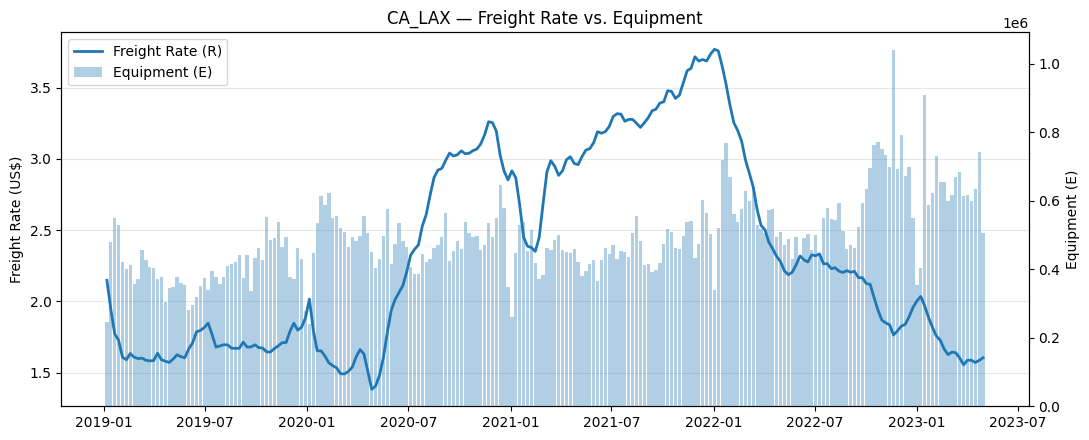

In [24]:
df_chart = df_filtered[df_filtered['id'] == 'CA_LAX']
df_chart

# --- pick the ID and filter (your sample shows 'CA_LAX')
kma_id = "CA_LAX"
df_chart = (
    df_filtered.loc[df_filtered['id'] == kma_id, ['week', 'R', 'E']]
      .dropna(subset=['week'])
      .sort_values('week')
      .copy()
)

# create the plot
fig, ax1 = plt.subplots(figsize=(11, 4.5))

# left y-axis: R as line
ax1.plot(df_chart['week'], df_chart['R'], label='Freight Rate (R)', linewidth=2, zorder=3)
ax1.set_ylabel('Freight Rate (US$)')
ax1.grid(True, axis='y', alpha=0.3)

# right y-axis: E as bars
ax2 = ax1.twinx()
# width given in days when x is datetime; 6 keeps bars nearly a week wide
ax2.bar(df_chart['week'], df_chart['E'], width=6, alpha=0.35, label='Equipment (E)', zorder=1)
ax2.set_ylabel('Equipment (E)')

# x-axis formatting
# ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# #ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# one legend combining both axes
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

ax1.set_title(f"{kma_id} — Freight Rate vs. Equipment")
fig.tight_layout()
plt.show()


### Chart 2 - Freight Rate vs Capacity Ratio (per KMA)

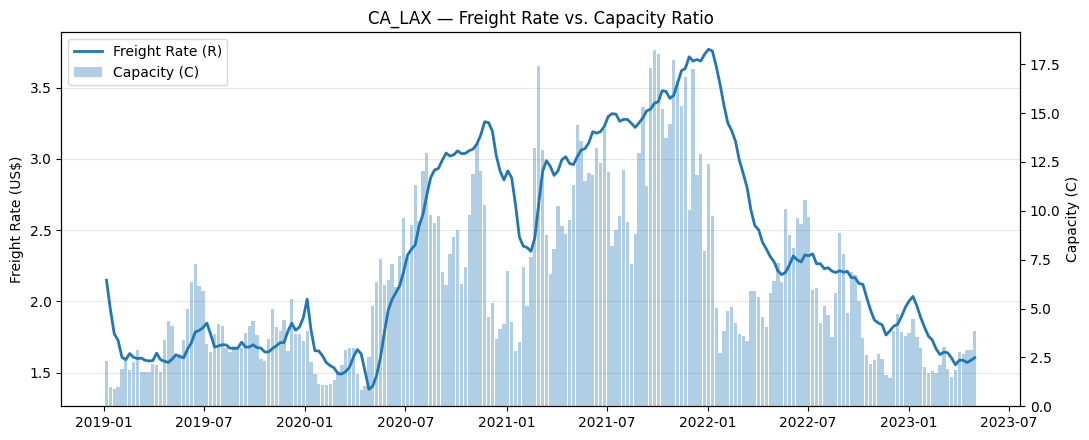

In [25]:
df_chart = df_filtered[df_filtered['id'] == 'CA_LAX']
df_chart

# --- pick the ID and filter (your sample shows 'CA_LAX')
kma_id = "CA_LAX"
df_chart = (
    df_filtered.loc[df_filtered['id'] == kma_id, ['week', 'R', 'C']]
      .dropna(subset=['week'])
      .sort_values('week')
      .copy()
)

# create the plot
fig, ax1 = plt.subplots(figsize=(11, 4.5))

# left y-axis: R as line
ax1.plot(df_chart['week'], df_chart['R'], label='Freight Rate (R)', linewidth=2, zorder=3)
ax1.set_ylabel('Freight Rate (US$)')
ax1.grid(True, axis='y', alpha=0.3)

# right y-axis: E as bars
ax2 = ax1.twinx()
# width given in days when x is datetime; 6 keeps bars nearly a week wide
ax2.bar(df_chart['week'], df_chart['C'], width=6, alpha=0.35, label='Capacity (C)', zorder=1)
ax2.set_ylabel('Capacity (C)')

# x-axis formatting
# ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# one legend combining both axes
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

ax1.set_title(f"{kma_id} — Freight Rate vs. Capacity Ratio")
fig.tight_layout()
plt.show()


### Smothing Features and Capacity Ratio

In [27]:
df_filtered = df_filtered.sort_values(['id', 't']).reset_index(drop=True)

# --- Helper: LOWESS per group, returns a Series aligned to original index
def lowess_per_group(g:pd.DataFrame, ycol: str, xcol: str = 't', frac: float = 0.15):
    x = g[xcol].to_numpy()
    y = g[ycol].to_numpy()
    mask = np.isfinite(x) & np.isfinite(y)
    out = pd.Series(np.nan, index=g.index)
    if mask.sum() >= 3:  # need a few points for smoothing
        sm = lowess(y[mask], x[mask], frac=frac, return_sorted=False)
        out.loc[g.index[mask]] = sm
    return out

# --- LOWESS smoothing of L and E by id
df_filtered['L_smooth'] = df_filtered.groupby('id', group_keys=False).apply(lambda g: lowess_per_group(g, 'L'))
df_filtered['E_smooth'] = df_filtered.groupby('id', group_keys=False).apply(lambda g: lowess_per_group(g, 'E'))

# --- Replace L and E with ceil(smoothed) where available
df_filtered.loc[df_filtered['L_smooth'].notna(), 'L'] = np.ceil(df_filtered.loc[df_filtered['L_smooth'].notna(), 'L_smooth'])
df_filtered.loc[df_filtered['E_smooth'].notna(), 'E'] = np.ceil(df_filtered.loc[df_filtered['E_smooth'].notna(), 'E_smooth'])

# Clean temp columns if you don't need them
df_filtered = df_filtered.drop(columns=['L_smooth', 'E_smooth'])

# --- C = L/E -> Replace CAPACITY Indicator
df_filtered['C'] = df_filtered['L'] / df_filtered['E']

# Comute logs, set to NaN if original value is <= 0
for col_src, col_out in [('R', 'r'), ('C', 'c'), ('F', 'f')]:
    valid = df_filtered[col_src] > 0
    df_filtered[col_out] = np.where(valid, np.log(df_filtered[col_src]), np.nan)


/tmp/ipykernel_1152/3988482713.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered['L_smooth'] = df_filtered.groupby('id', group_keys=False).apply(lambda g: lowess_per_group(g, 'L'))
/tmp/ipykernel_1152/3988482713.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered['E_smooth'] = df_filtered.groupby('id', group_keys=False).apply(lambda g: lowess_per_group(g, 'E'))


### Chart 3 - Histogram of feature distribution

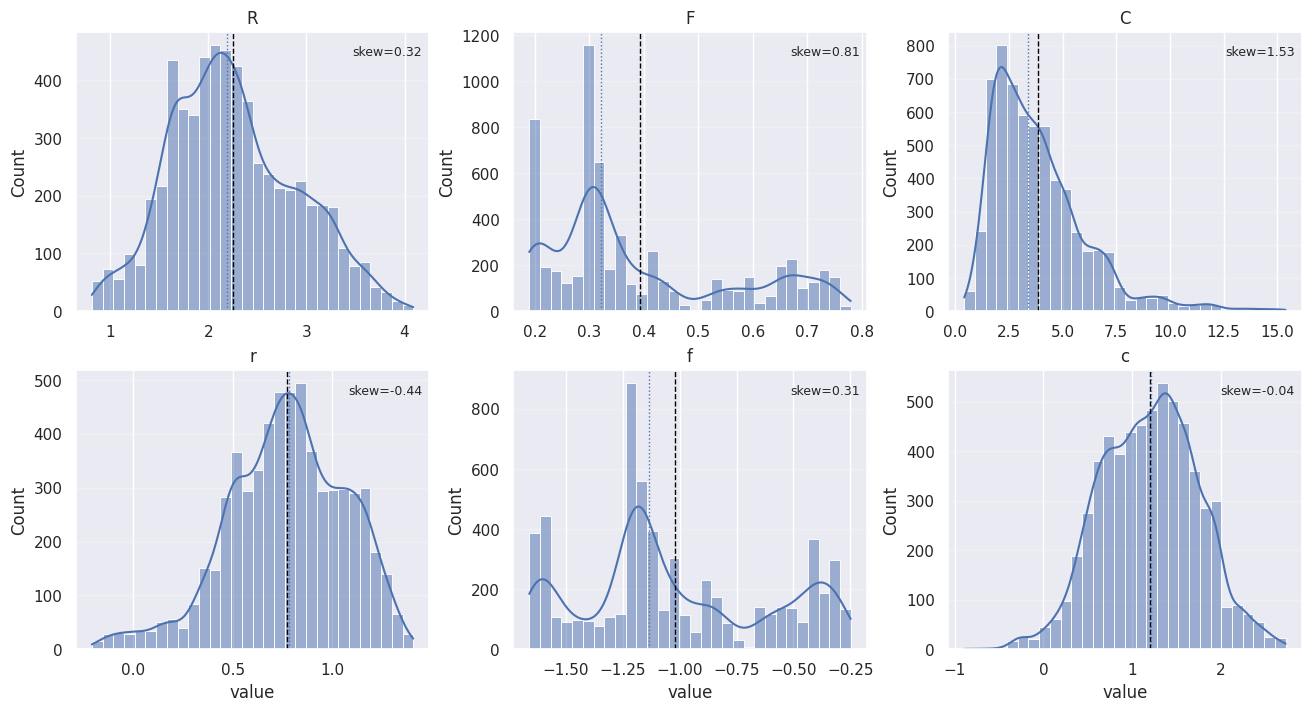

In [28]:
sns.set_theme()

cols_top = ['R', 'F', 'C']
cols_bot = ['r', 'f', 'c']

fig, axes = plt.subplots(2, 3, figsize=(13, 7), constrained_layout=True)

def plot_hist(ax, s, title):
    s = pd.Series(s).dropna()
    sns.histplot(s, bins=30, kde=True, ax=ax)
    # mean/median
    m, md = s.mean(), s.median()
    ax.axvline(m, linestyle='--', linewidth=1, color = 'black')
    ax.axvline(md, linestyle=':',  linewidth=1)
    # annotate skewness
    ax.text(0.98, 0.95, f"skew={skew(s, nan_policy='omit'):.2f}",
            transform=ax.transAxes, ha='right', va='top', fontsize=9)
    ax.set_title(title)
    ax.grid(True, axis='y', alpha=0.25)

# top row: R, F, C
for j, col in enumerate(cols_top):
    plot_hist(axes[0, j], df_filtered[col], col)

# bottom row: r, f, c=
for j, col in enumerate(cols_bot):
    plot_hist(axes[1, j], df_filtered[col], col)

# nicer labels (optional)
for ax in axes[1]:
    ax.set_xlabel("value")
for ax in axes[0]:
    ax.set_xlabel("")

plt.show()


### Chart 4 - Scatter plots - relating features

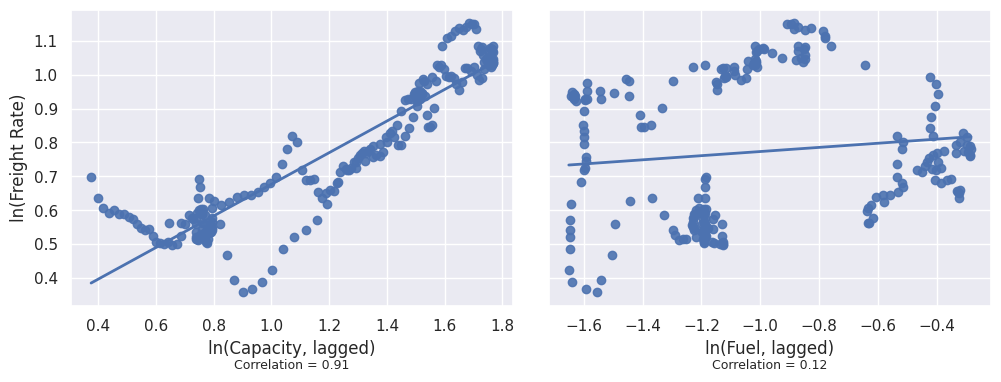

In [29]:
df_filtered = df_filtered.sort_values(['t', 'id']).reset_index(drop=True)

# --- Logs (guard against non-positive values)
for src, dst in [('R','lnR'), ('F','lnF'), ('C','lnC')]:
    valid = df_filtered[src] > 0
    df_filtered[dst] = np.where(valid, np.log(df_filtered[src]), np.nan)

# --- Cross-section means by time t
means_t = (
    df_filtered.groupby('t')[['lnR', 'lnC', 'lnF']]
      .mean()
      .sort_index()
      .rename(columns={'lnR': 'lnR_m', 'lnC': 'lnC_m', 'lnF': 'lnF_m'})
)

# 1-period lag of time-means
means_t['L_lnC_m'] = means_t['lnC_m'].shift(1)
means_t['L_lnF_m'] = means_t['lnF_m'].shift(1)

# Data for each subplot (drop missing)
plot_c = means_t[['lnR_m', 'L_lnC_m']].dropna().rename(columns={'L_lnC_m': 'x'})
plot_f = means_t[['lnR_m', 'L_lnF_m']].dropna().rename(columns={'L_lnF_m': 'x'})

# Plot chart 
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig.subplots_adjust(wspace=0.08, bottom=0.12) 

# panel data
pairs = [
    (plot_c, "ln(Capacity, lagged)", axes[0]),
    (plot_f, "ln(Fuel, lagged)",    axes[1]),
]

for data, xlabel, ax in pairs:
    sns.regplot(data=data, x='x', y='lnR_m', ci=None,
                scatter_kws={'s': 36, 'alpha': 0.9},
                line_kws={'linewidth': 2}, ax=ax)
    ax.set_xlabel(xlabel)

    # Pearson correlation (dropna already done in plot_* frames)
    r, p = pearsonr(data['x'], data['lnR_m'])

    # put text BELOW the x-axis; (-0.18) is below the axis in Axes coords
    ax.text(0.5, -0.18, f"Correlation = {r:.2f}",
            transform=ax.transAxes, ha='center', va='top', fontsize=9)

# labels / cosmetics
axes[0].set_ylabel("ln(Freight Rate)")
axes[1].set_ylabel("")
# for ax in axes:
#     ax.set_box_aspect(None) 
    # ax.set_box_aspect(1)

# tighten spacing & margins (no tight_layout())
fig.subplots_adjust(left=0.07, right=0.99, top=0.96, bottom=0.22, wspace=0.08)

plt.show()


### Save final df for next steps:

In [30]:
df_filtered.to_parquet('data/data_for_model.parquet', index=False)